# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: Xi Han, Haoran Zhao

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix
import seaborn as sns
import itertools

%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [7]:
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")

display(bikes_df.head())
bikes_df.describe()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [8]:
bikes_df["year"] = bikes_df["dteday"].apply(lambda x:1 if x.split("-")[0]=="2012" else 0)
bikes_df["months"] = bikes_df["dteday"].apply(lambda x: int(x.split("-")[1]))
bikes_df["counts"] = bikes_df["casual"] +bikes_df["registered"]

In [22]:
bikes_df.head(-5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,months,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,2012-12-31,1,14,0,1,1,2,0.28,0.2727,0.45,0.2239,62,185,1,12,247
17370,2012-12-31,1,15,0,1,1,2,0.28,0.2879,0.45,0.1343,69,246,1,12,315
17371,2012-12-31,1,16,0,1,1,2,0.26,0.2576,0.48,0.1940,30,184,1,12,214
17372,2012-12-31,1,17,0,1,1,2,0.26,0.2879,0.48,0.0896,14,150,1,12,164


In [30]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
year            int64
months          int64
counts          int64
dtype: object

In [32]:
# your code here
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")

In [4]:
# your code here
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [5]:
# your code here
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
dteday        17379 non-null object
season        17379 non-null int64
hour          17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.7+ MB


In [6]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


*Your answer here*

The min of temp and atemp should be below 0 Celsius and the max of temp and atemp should be above 30 Celsius in DC. The average of temp and atemp should also be around 15 Celsius. Looks like these two column either have some data issues or are normalized already.

humidity and windspeed seem to have been normalized too. 

dteday is a pandas object, which is not useful when we want to extract the elements of the date such as the year, month, and day. 

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [26]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'], format='%Y-%m-%d')
# !!!!!!!!!!!

In [27]:
bikes_df['dteday']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17374   2012-12-31
17375   2012-12-31
17376   2012-12-31
17377   2012-12-31
17378   2012-12-31
Name: dteday, Length: 17379, dtype: datetime64[ns]

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [8]:
# your code here
bikes_df['year'] = bikes_df['dteday'].dt.year - 2011
# !!!!!!!!!!!!
bikes_df['month'] = bikes_df['dteday'].dt.month
bikes_df['counts'] = bikes_df['casual'] + bikes_df['registered']

In [80]:
# your code here
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,months,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 


IQR stands for Interquartile Range, which is a statistical measure used to describe the spread or variability of a dataset. It is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the data.

array([[<Axes: xlabel='hour', ylabel='hour'>,
        <Axes: xlabel='temp', ylabel='hour'>,
        <Axes: xlabel='atemp', ylabel='hour'>,
        <Axes: xlabel='hum', ylabel='hour'>,
        <Axes: xlabel='windspeed', ylabel='hour'>,
        <Axes: xlabel='casual', ylabel='hour'>,
        <Axes: xlabel='registered', ylabel='hour'>,
        <Axes: xlabel='counts', ylabel='hour'>],
       [<Axes: xlabel='hour', ylabel='temp'>,
        <Axes: xlabel='temp', ylabel='temp'>,
        <Axes: xlabel='atemp', ylabel='temp'>,
        <Axes: xlabel='hum', ylabel='temp'>,
        <Axes: xlabel='windspeed', ylabel='temp'>,
        <Axes: xlabel='casual', ylabel='temp'>,
        <Axes: xlabel='registered', ylabel='temp'>,
        <Axes: xlabel='counts', ylabel='temp'>],
       [<Axes: xlabel='hour', ylabel='atemp'>,
        <Axes: xlabel='temp', ylabel='atemp'>,
        <Axes: xlabel='atemp', ylabel='atemp'>,
        <Axes: xlabel='hum', ylabel='atemp'>,
        <Axes: xlabel='windspeed', ylabel='a

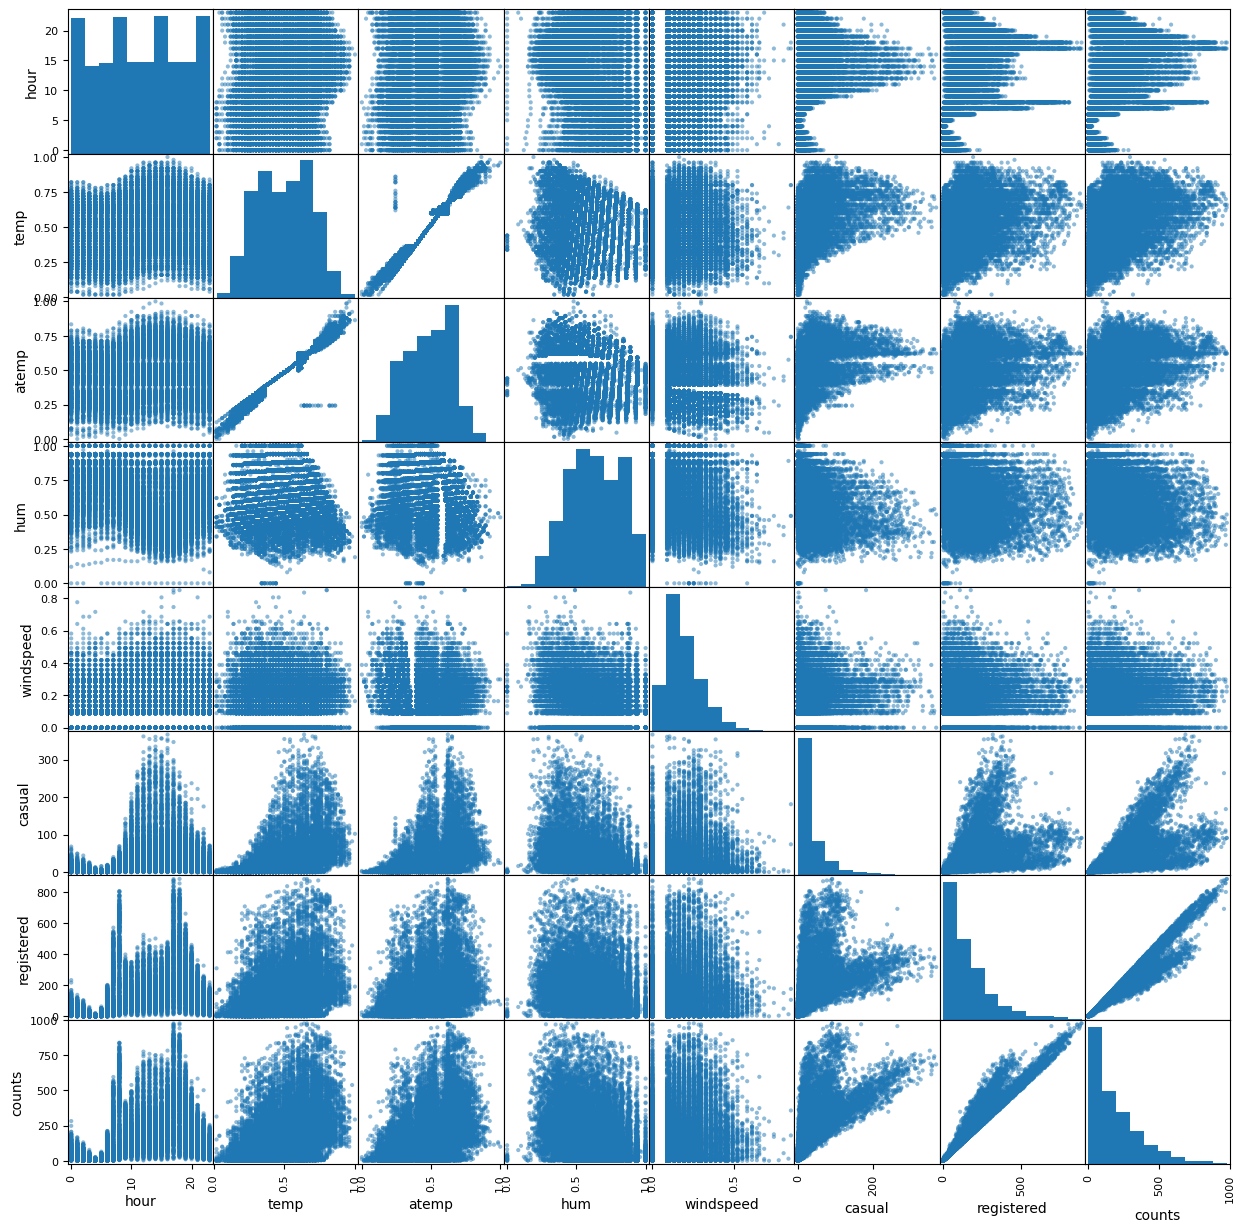

In [37]:
scatter_matrix(bikes_df, figsize =(15,15))

/tmp/ipykernel_30446/3724433749.py:1: FutureWarning: ['dteday', 'season', 'holiday', 'weekday', 'workingday', 'weather', 'year', 'months'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = bikes_df.groupby("hour").agg(["mean"])[["casual","registered"]].reset_index()


<Axes: xlabel='hour', ylabel='mean'>

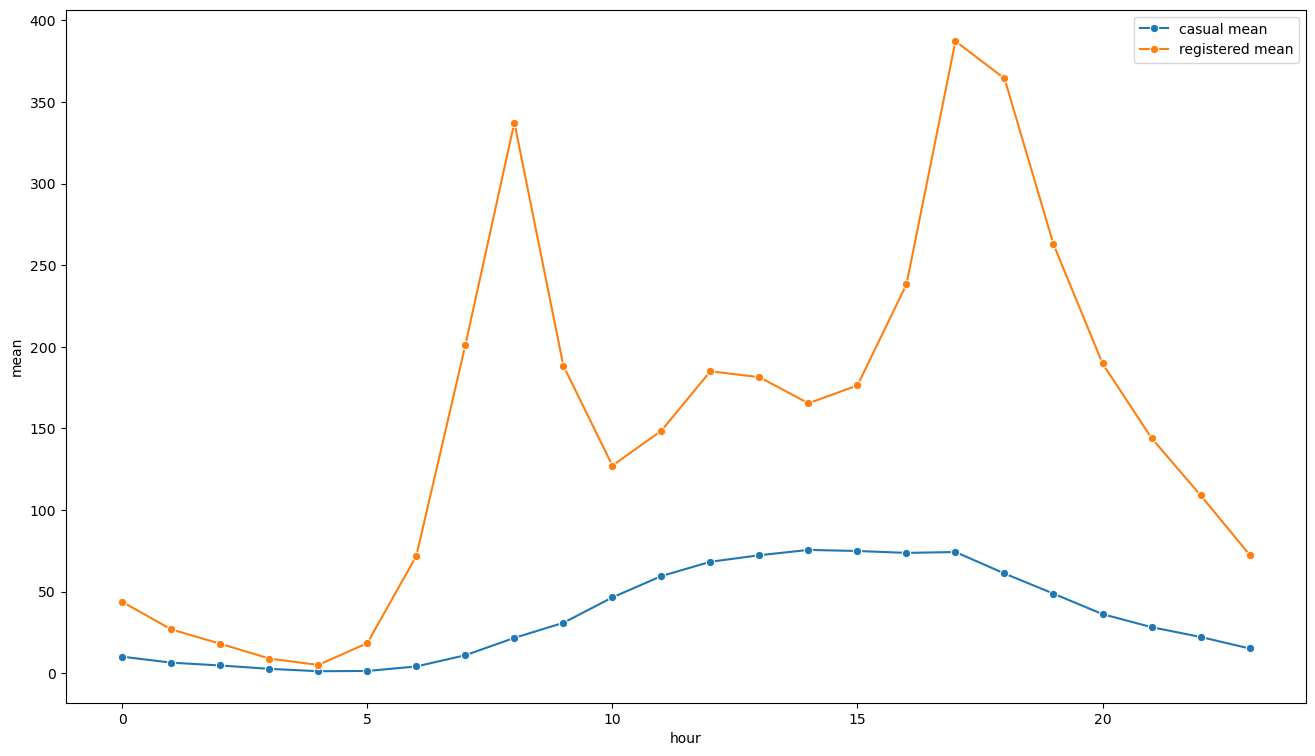

In [63]:
df = bikes_df.groupby("hour").agg(["mean"])[["casual","registered"]].reset_index()
plt.figure(figsize = (16,9))
sns.lineplot(data = df, x = df["hour"], y = df["casual"]["mean"], label = "casual mean", marker = "o")
sns.lineplot(data = df, x = df["hour"], y = df["registered"]["mean"], label = "registered mean", marker = "o")

In [61]:
df.columns
# !!!multiindex

MultiIndex([(      'hour',     ''),
            (    'casual', 'mean'),
            ('registered', 'mean')],
           )

In [102]:
df2 = bikes_df.groupby(["weather", "hour"]).agg(["mean"])[["casual", "registered"]].dropna().reset_index()
df2= df2.droplevel(1, axis=1)
df2

/tmp/ipykernel_30446/461217551.py:1: FutureWarning: ['dteday', 'season', 'holiday', 'weekday', 'workingday', 'year', 'months'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df2 = bikes_df.groupby(["weather", "hour"]).agg(["mean"])[["casual", "registered"]].dropna().reset_index()


,weather,hour,casual,registered
0,1,0,11.429448,47.732106
1,1,1,6.951020,27.444898
2,1,2,5.008368,17.809623
3,1,3,2.868132,9.127473
4,1,4,1.273523,5.140044
...,...,...,...,...
70,3,22,8.727273,61.618182
71,3,23,8.746269,40.626866
72,4,1,1.000000,22.000000
73,4,16,1.000000,35.000000


/tmp/ipykernel_30446/566834736.py:1: FutureWarning: ['season', 'holiday', 'weekday', 'workingday', 'year', 'months'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df2 = bikes_df.groupby(["weather", "hour"]).agg(["mean"])[["casual", "registered"]].reset_index().dropna().droplevel(1, axis=1)


<Figure size 1600x1600 with 0 Axes>

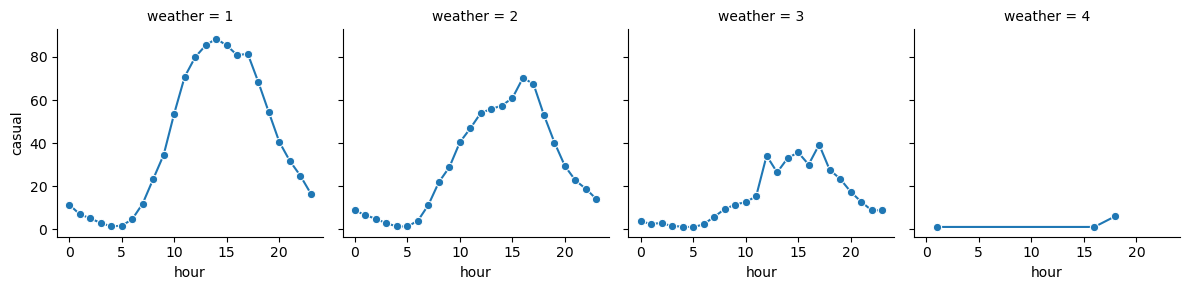

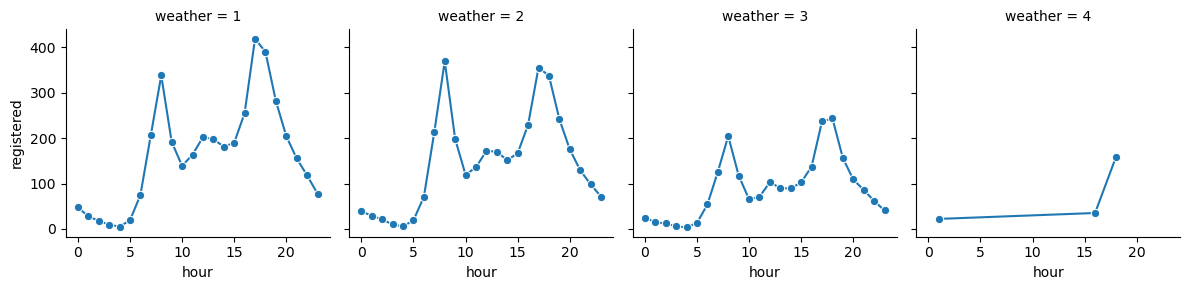

In [114]:
df2 = bikes_df.groupby(["weather", "hour"]).agg(["mean"])[["casual", "registered"]].reset_index().dropna().droplevel(1, axis=1)
# !!!!droplevel()
df2 = df2.rename(columns={("casual","mean"):"casual",
                          ("registered", "mean"): "registered"})

plt.figure(figsize = (16,16))
for feature in ["casual", "registered"]:
    g = sns.FacetGrid(df2, col="weather", col_wrap=4)
    # row and col expects a string instead of a Series
    g.map_dataframe(sns.lineplot, x = "hour", y = feature, marker ="o")

In [116]:
bikes_df

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,months,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,1,12,119
17375,2012-12-31,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,1,12,89
17376,2012-12-31,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,1,12,90
17377,2012-12-31,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,1,12,61


<Figure size 1600x1600 with 0 Axes>

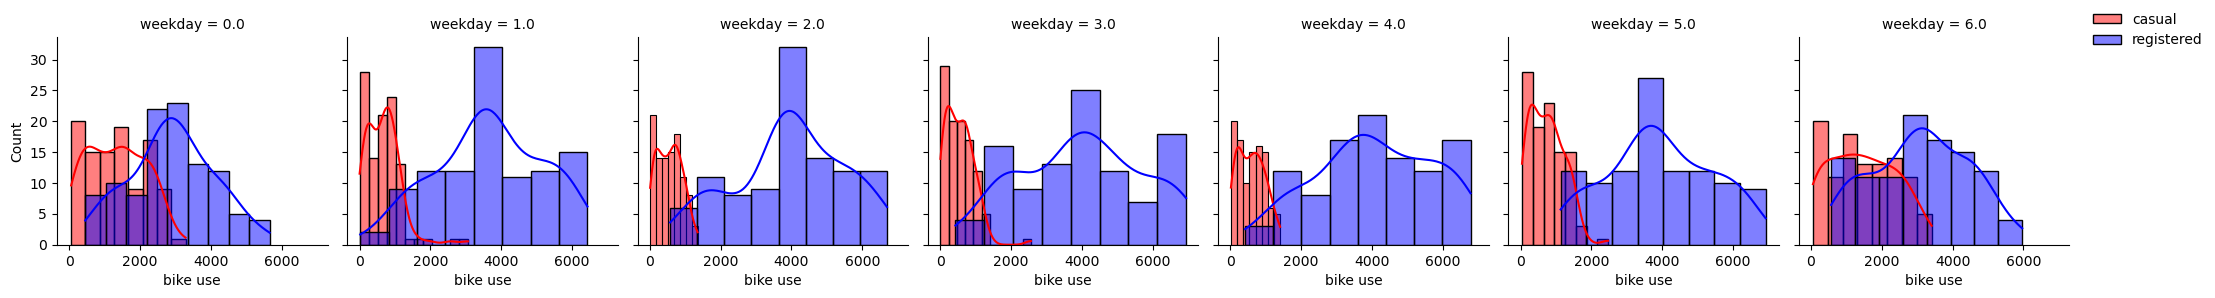

In [9]:
bikes_df["dteday"] = pd.to_datetime(bikes_df["dteday"], format = "%Y-%m-%d")
bikes_by_day = bikes_df.groupby("dteday").agg({"weekday": "mean",
                                "weather": "max",
                                "season": "mean",
                                "temp":"mean",
                                "atemp":"mean",
                                "hum":"mean",
                                "windspeed":"mean",
                                "casual":"sum",
                                "registered":"sum",
                                "counts":"sum"}).reset_index()
plt.figure(figsize =(16,16))
g = sns.FacetGrid(bikes_by_day, col ="weekday", col_wrap=7)
g.map(sns.histplot, "casual", alpha = 0.5, color = "r", label = "casual", kde = True)
g.map(sns.histplot, "registered", alpha = 0.5, color = "b", label = "registered", kde = True)
g.set_xlabels("bike use")
g.add_legend(loc = "upper right")
# !!!!!!!!!!!

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1600x1600 with 0 Axes>

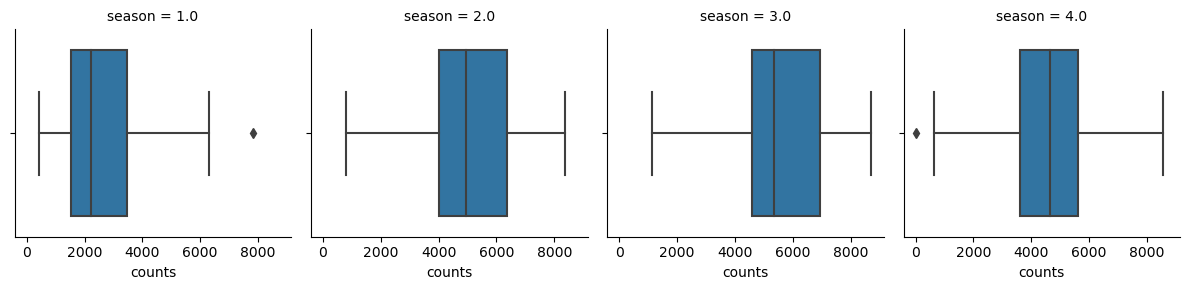

In [23]:
plt.figure(figsize = (16,16))
g = sns.FacetGrid(bikes_by_day, col = "season", col_wrap=4)
g.map(sns.boxplot, "counts", showfliers = True)

In [24]:
s1 = bikes_by_day[bikes_by_day["season"]==1.0]
s3 = bikes_by_day[bikes_by_day["season"]==4.0]

s1 = s1.sort_values(by="counts")
s3 = s3.sort_values(by ="counts")

print(s1.iloc[-1])
print(s3.iloc[1])

dteday        2012-03-17 00:00:00
weekday                       6.0
weather                         2
season                        1.0
temp                     0.514167
atemp                    0.505046
hum                      0.755833
windspeed                0.110704
casual                       3155
registered                   4681
counts                       7836
Name: 441, dtype: object
dteday        2011-10-29 00:00:00
weekday                       6.0
weather                         3
season                        4.0
temp                     0.254167
atemp                    0.227912
hum                        0.8825
windspeed                0.351371
casual                         57
registered                    570
counts                        627
Name: 301, dtype: object


### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

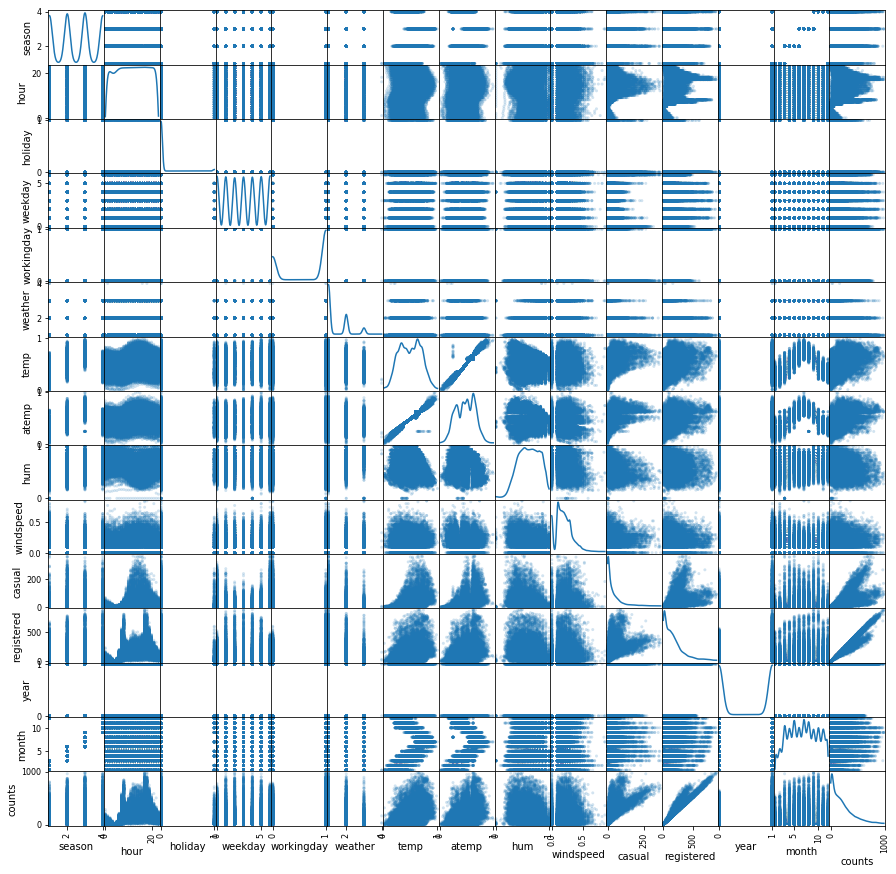

In [268]:
# your code here
scatter_matrix(bikes_df, alpha=0.2, diagonal='kde', figsize=(15,15))
plt.show()

/tmp/ipykernel_30446/714874081.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(bikes_df.corr())


<Axes: >

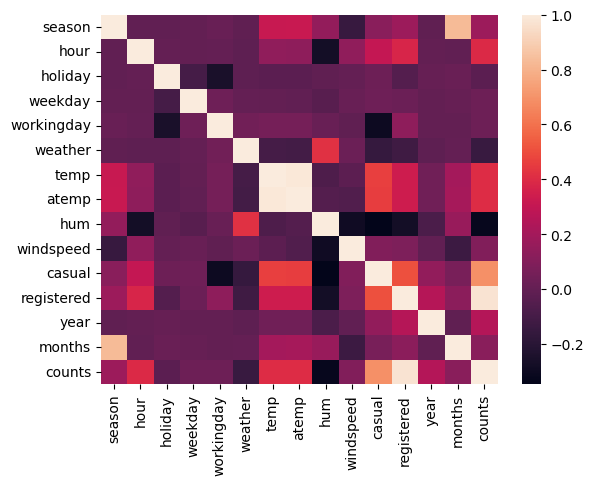

In [149]:
sns.heatmap(bikes_df.corr())

*your answer here* 

* temp vs atemp: strong positive correlation
* month vs temp/atemp: temp/atemp is higher during the summer and cold during the winter.
* season vs month: 3 months are corresponding to 1 season. 
* workingday vs weekday: weekday 1 to 5 has workingday 1, and weekday 0 and 6 has workingday 0.
* counts vs registered vs casuals: strong positive correlation
* counts vs windspeed: when windspeed is higher than 0.5, counts drops dramatically.
* counts vs hour: counts peak during commute hours and at minimum in the early morning and late night.
* counts vs month: counts are lower in January, Feburary, November and December compared to other months.

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

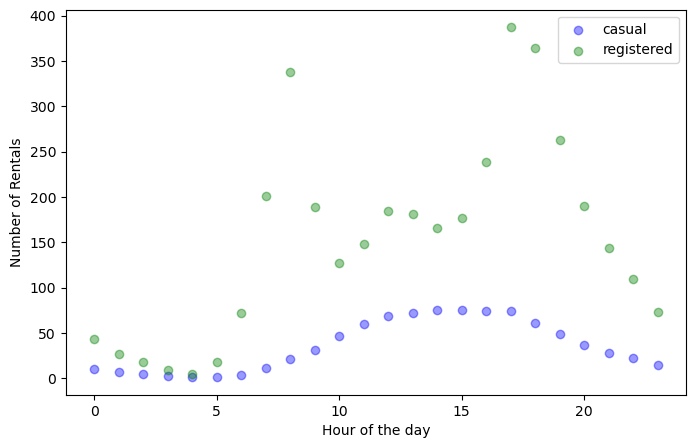

In [156]:
# your code here
average = bikes_df.groupby(['hour']).agg({'casual':'mean', 'registered':'mean'})
# if use agg("mean"), returns single index
# if use agg(["mean"]), returns multi index
# !!!!

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_ylabel('Number of Rentals')
ax.set_xlabel('Hour of the day')
ax.scatter(average.index.values, average['casual'].values, alpha=0.4 , c='b', label='casual')
# !!!!!!!
# use average.index.values and
ax.scatter(average.index.values, average['registered'].values, alpha=0.4, c='g', label='registered')
ax.legend()
fig.savefig("fig/riders.png")

*your answer here*

The registered rentals picked during commute hours from 8 am to 10am and from 4pm to 7pm. The causual rentals increased from 7 am, peaked from 12pm to 5pm and trending down afterwards.

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [159]:
# your code here
average = bikes_df.groupby(['weather','hour']).agg({'casual':'mean','registered':'mean'}).\
                            reset_index(level=['weather', 'hour'])
# Only remove the given levels from the index. Removes all levels by default.
average.head()

,weather,hour,casual,registered
0,1,0,11.429448,47.732106
1,1,1,6.951020,27.444898
2,1,2,5.008368,17.809623
3,1,3,2.868132,9.127473
4,1,4,1.273523,5.140044


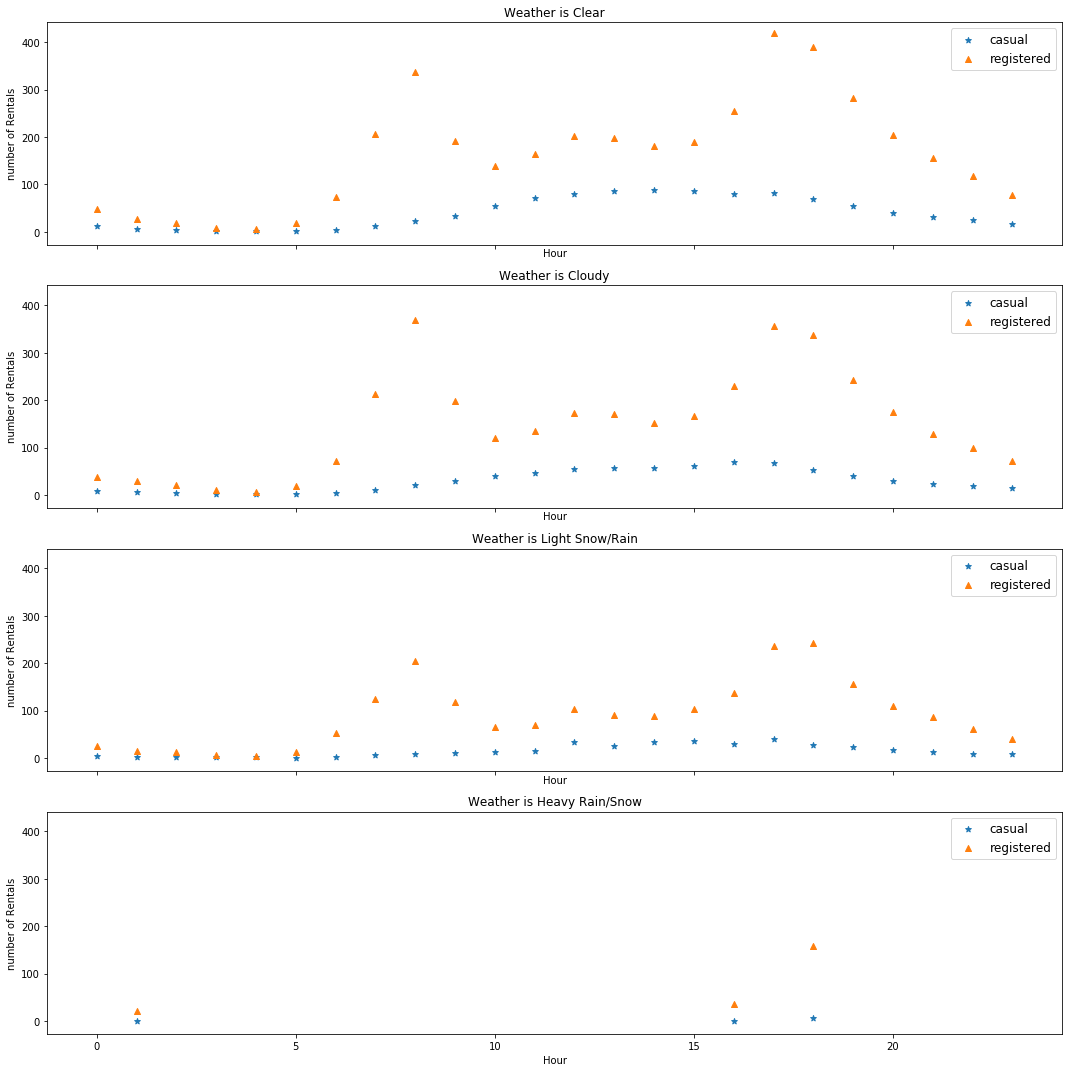

In [13]:
# your code here
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15, 15), sharex=True, sharey=True)

ax1.scatter(average.loc[average['weather']==1,['hour']], average.loc[average['weather']==1,['casual']],marker='*',label='casual')
ax1.scatter(average.loc[average['weather']==1,['hour']], average.loc[average['weather']==1,['registered']],marker='^',label='registered')
ax1.set_title('Weather is Clear')
ax1.set_xlabel('Hour')
ax1.set_ylabel('number of Rentals')
ax1.legend(prop={'size': 12})

ax2.scatter(average.loc[average['weather']==2,['hour']], average.loc[average['weather']==2,['casual']],marker='*',label='casual')
ax2.scatter(average.loc[average['weather']==2,['hour']], average.loc[average['weather']==2,['registered']],marker='^',label='registered')
ax2.set_title('Weather is Cloudy')
ax2.set_xlabel('Hour')
ax2.set_ylabel('number of Rentals')
ax2.legend(prop={'size': 12})

ax3.scatter(average.loc[average['weather']==3,['hour']], average.loc[average['weather']==3,['casual']],marker='*',label='casual')
ax3.scatter(average.loc[average['weather']==3,['hour']], average.loc[average['weather']==3,['registered']],marker='^',label='registered')
ax3.set_title('Weather is Light Snow/Rain')
ax3.set_xlabel('Hour')
ax3.set_ylabel('number of Rentals')
ax3.legend(prop={'size': 12})

ax4.scatter(average.loc[average['weather']==4,['hour']], average.loc[average['weather']==4,['casual']],marker='*',label='casual')
ax4.scatter(average.loc[average['weather']==4,['hour']], average.loc[average['weather']==4,['registered']],marker='^',label='registered')
ax4.set_title('Weather is Heavy Rain/Snow')
ax4.set_xlabel('Hour')
ax4.set_ylabel('number of Rentals')
ax4.legend(prop={'size': 12})
plt.tight_layout()

f.savefig('fig/weather.png')

*your answer here*

The relationship still maitains for weather = 1 ,2, 3 when the weather is nice or moderate, although the number of retental decreased as weather getting worse. However, when weather = 4 with heavy rain/snow, the relationship disappeared and almost no rentals for the entire day.

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [6]:
# your code here
bikes_df['dteday'] = bikes_df['dteday'].dt.normalize()

bikes_by_day = bikes_df.groupby(['dteday']).agg({'weekday':'mean',
                                                 'weather':'max',
                                                 'season':'mean',
                                                 'temp':'mean',
                                                 'atemp':'mean',
                                                 'windspeed':'mean',
                                                 'hum':'mean',
                                                 'casual':'sum',
                                                 'registered':'sum',
                                                 'counts':'sum'}).reset_index(level='dteday')

bikes_by_day.head()

AttributeError: Can only use .dt accessor with datetimelike values

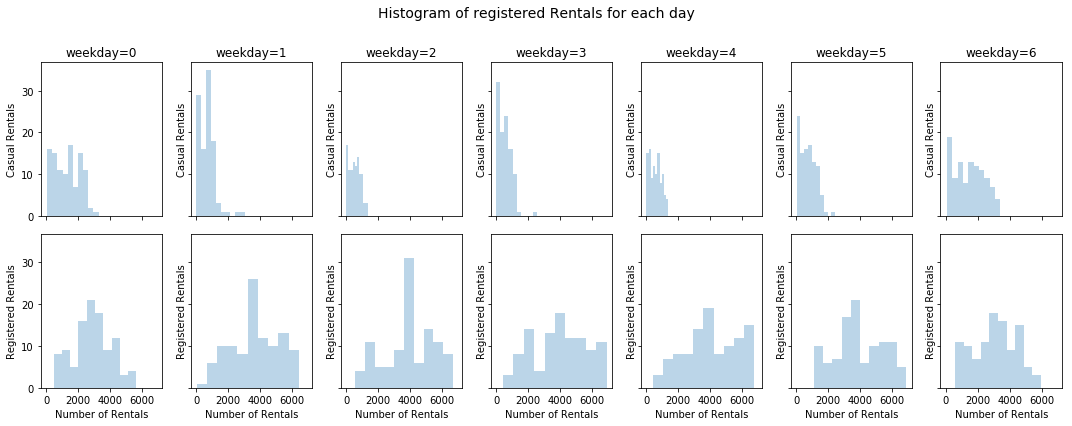

In [15]:
# your code here
f, axarr = plt.subplots(2, 7, figsize=(15, 6), sharex=True, sharey=True)

for i in range(7):
    day = bikes_by_day[bikes_by_day['weekday']==i]
    axarr[0, i].hist(day['casual'], alpha=0.3)
    axarr[0, i].set_title('weekday=%i'%i)
    #axarr[0, i].set_xlabel('Number of Rentals')
    axarr[0, i].set_ylabel('Casual Rentals')

    day = bikes_by_day[bikes_by_day['weekday']==i]
    axarr[1, i].hist(day['registered'],alpha=0.3)
    #axarr[1, i].set_title('weekday=%i'%i)
    axarr[1, i].set_xlabel('Number of Rentals')
    axarr[1, i].set_ylabel('Registered Rentals')

f.suptitle('Histogram of registered Rentals for each day',fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.85)

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

In [15]:
data

AttributeError: 'list' object has no attribute 'T'

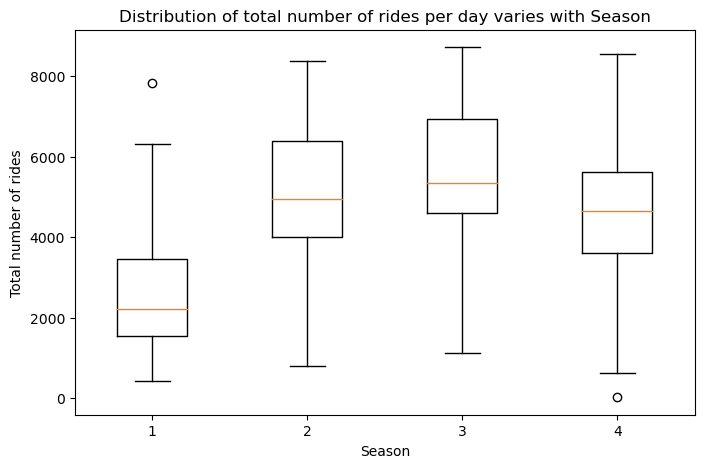

In [10]:
# your code here 
winter = bikes_by_day.loc[bikes_by_day['season']==1]
spring = bikes_by_day.loc[bikes_by_day['season']==2]
summer = bikes_by_day.loc[bikes_by_day['season']==3]
fall = bikes_by_day.loc[bikes_by_day['season']==4]
data = [winter['counts'],spring['counts'],summer['counts'],fall['counts']]
# data is a list of Series

f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlabel('Season')
ax.set_ylabel('Total number of rides')
ax.set_title('Distribution of total number of rides per day varies with Season')
ax.boxplot(data)
# the input can be Array or a sequence of vectors.

f.savefig('fig/season.png')

In [17]:
# your code here
print(winter.temp.mean())
print(spring.temp.mean())
winter.loc[winter['counts'].idxmax()]
# !!!!!
# A single label, e.g. 5 or 'a', (note that 5 is interpreted as a label of the index, and never as an integer position along the index).

0.29774755724431445
0.5444051275992435


dteday        2012-03-17 00:00:00
weekday                         6
weather                         2
season                          1
temp                     0.514167
atemp                    0.505046
windspeed                0.110704
hum                      0.755833
casual                       3155
registered                   4681
counts                       7836
Name: 441, dtype: object

In [18]:
# your code here
fall.loc[fall['counts'].idxmin()]

dteday        2012-10-29 00:00:00
weekday                         1
weather                         3
season                          4
temp                         0.44
atemp                      0.4394
windspeed                  0.3582
hum                          0.88
casual                          2
registered                     20
counts                         22
Name: 667, dtype: object

*your answer here* 

3/17/2012 is an outlier date to have a much larger number of rentals compared to the rest of days during the summer. However, I do not think this is an error. The tempreture of the day is 0.51 which is much warmer than the rest of the winter and close to the average temperture in the spring time. In addition, weather and the windspeed are also very nice. Especially, it is Saturday. After a long cold winter, more people would like to go out at a warm and nice Saturday.

10/29/2018 is the day Hurricane Sandy, one of the worst hurricane, landed the east coast. It makes sense people stayed home for such day.

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



ancillary variables include variables that are recorded but not used in designing the experiment and are not incorporated into the formal analysis of the primary experimental response variable.

In [8]:
from pandas.api.types import CategoricalDtype

cat = CategoricalDtype(ordered=False)
cols = ["season", "weather", "weekday","months"]
for col in cols:
    bikes_df[col] = bikes_df[col].astype(cat)

bikes_df.dtypes

NameError: name 'bikes_df' is not defined

In [108]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(drop = "if_binary", sparse=False, handle_unknown="error")
oh_var = oh.fit_transform(bikes_df[cols])
oh_var = pd.DataFrame(data = oh_var)

bikes_oh = pd.concat([bikes_df, oh_var], axis= 1)
pd.set_option("display.max_columns", None)
# set_option(pat, value)
# By setting display.max_columns to None, it means that there is no maximum limit on the number of columns that pandas will display
bikes_oh.head()

/home/ting/ENTER/envs/cs109a/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,months,counts,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
cols

['season', 'weather', 'weekday', 'months']

In [48]:
train_data, test_data = train_test_split(bikes_oh, test_size=0.2, stratify = bikes_oh["months"], shuffle=True)
# stratify expects array like
# using stratify = ["months"] is wrong as this is any array with only one element

In [9]:
BSS_train = pd.read_csv("data/BSS_train.csv", index_col=0).drop(["dteday", "casual", "registered"], axis =1)
BSS_test = pd.read_csv("data/BSS_test.csv", index_col=0).drop(["dteday", "casual","registered"], axis =1)

pd.set_option("display.max_columns", None)
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,summer,fall,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [111]:
# your code here
bikes_df_recoded = pd.get_dummies(bikes_df, columns=['season', 'months', 'weekday', 'weather'], drop_first=True)
# pd.get_dummies(columns = [...]) needs to concat later
# By dropping the first column, you essentially create a reference category, 
# and the information about that category is implicitly captured in the absence of the other encoded categories. 
# 0, 0, 0 indicates the season1, 1, 0, 0, indicates season2, for each column, holding other columns unchanged, 0 indicates season1, 1 indicates that season
# # The main reason for dropping the first column is to avoid multicollinearity in models that assume independence among the features. 

In [20]:
#your code here
bikes_df_recoded.columns

Index(['dteday', 'hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'year', 'counts', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [61]:
# your code here
train_data, test_data = train_test_split(bikes_df_recoded, test_size = 0.2, stratify=bikes_df['months'])

In [63]:
# your code here
bikes_df['months'].value_counts().sort_index()

1     1429
2     1341
3     1473
4     1437
5     1488
6     1440
7     1488
8     1475
9     1437
10    1451
11    1437
12    1483
Name: months, dtype: int64

In [23]:
# your code here
train_data[['month_2', 'month_3', 'month_4', 'month_5',
            'month_6', 'month_7', 'month_8', 'month_9', 
            'month_10', 'month_11', 'month_12']].apply(pd.Series.value_counts)
# dataframe.apply: Apply a function along an axis of the DataFrame. default is axis =0 (across rows)
# if using t in train_data, t will be the column names
# !!!!!!!!!!!!

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,12830,12725,12753,12713,12751,12713,12723,12753,12742,12753,12717
1,1073,1178,1150,1190,1152,1190,1180,1150,1161,1150,1186


In [24]:
# your code here
test_data[['month_2', 'month_3', 'month_4', 'month_5',
           'month_6', 'month_7', 'month_8', 'month_9', 
           'month_10', 'month_11', 'month_12']].apply(pd.Series.value_counts)

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3208,3181,3189,3178,3188,3178,3181,3189,3186,3189,3179
1,268,295,287,298,288,298,295,287,290,287,297


*your answer here*

The argument of stratify=bikes_df['month'] along with the argument of test_size = 0.2 that I passed into train_test_split function makes the test set to have 20% of the total observations within each month group. 

#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [5]:
# your code here
BSS_train = pd.read_csv("data/BSS_train.csv", index_col='Unnamed: 0')
BSS_test = pd.read_csv("data/BSS_test.csv", index_col='Unnamed: 0')

In [6]:
# your code here
BSS_train.drop(['dteday', 'casual', 'registered'], axis=1, inplace=True)
BSS_test.drop(['dteday', 'casual', 'registered'], axis=1, inplace=True)

In [27]:
BSS_test.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'counts', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


In [47]:
train_x = BSS_train.drop("counts", axis =1)
train_y = BSS_train["counts"]

test_x = BSS_test.drop("counts", axis =1)
test_y = BSS_test["counts"]

train_X = sm.add_constant(train_x)
results = OLS(train_y, train_X).fit()
print(results.summary())

test_X = sm.add_constant(test_x)
prediction_test = results.predict(test_X)

print("the r squared score for train data is %f." %results.rsquared)
print("the r squared score for test data is %f." %r2_score(test_y, prediction_test))

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        13:38:44   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.0

Text(0, 0.5, 'counts')

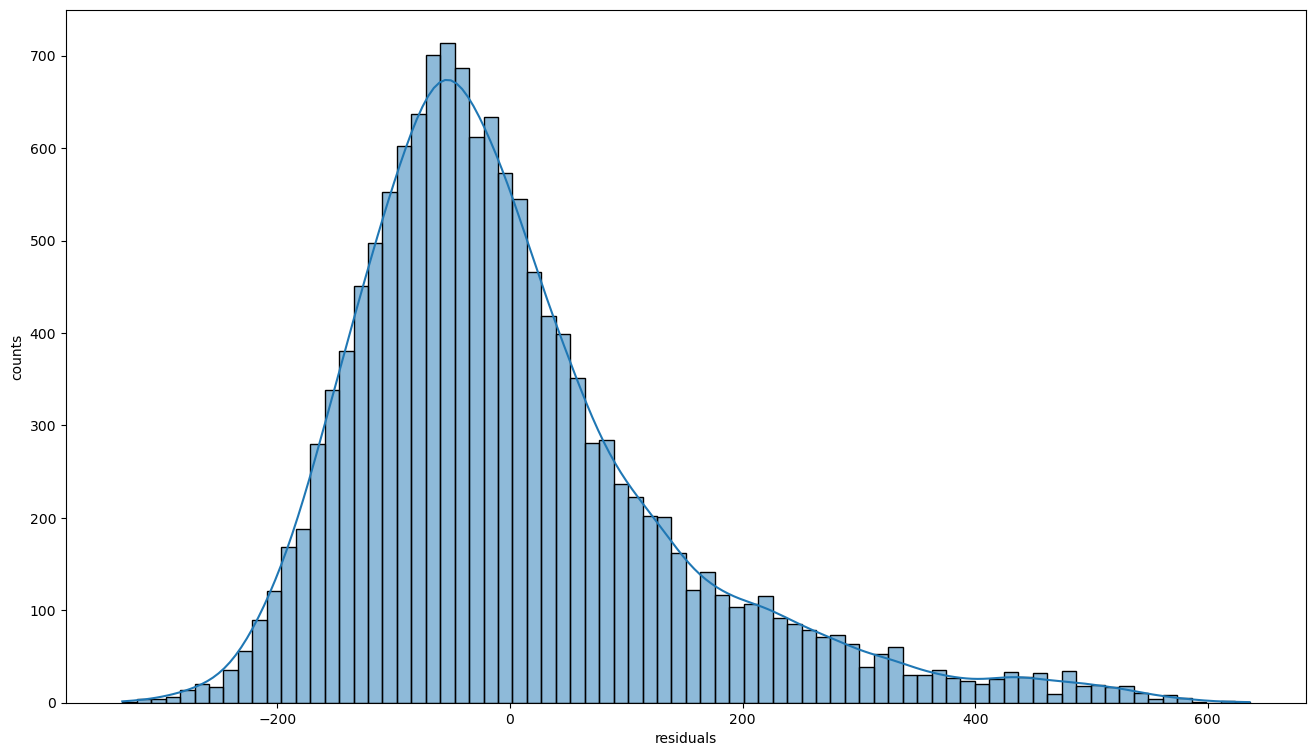

In [82]:
plt.figure(figsize = (16,9))
sns.histplot(data = results.resid, kde = True)
plt.xlabel("residuals")
plt.ylabel("counts")

Text(0, 0.5, 'residuals')

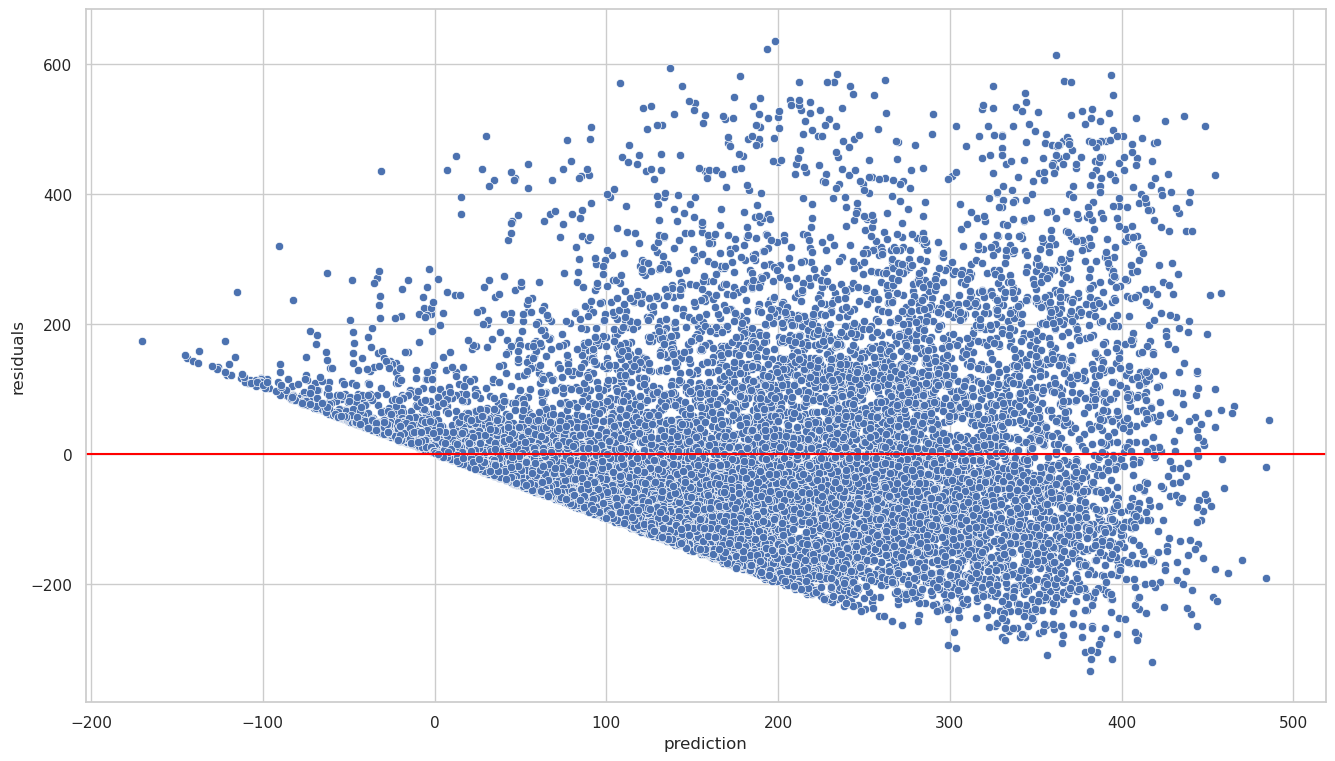

In [93]:
train_prediction = results.predict(train_X)
residual = train_y - train_prediction
plt.figure(figsize = (16,9))
sns.scatterplot(x = train_prediction, y = residual)
plt.axhline(0, np.min(train_prediction), np.max(train_prediction), color = "red")
plt.xlabel("prediction")
plt.ylabel("residuals")


In [44]:
train_X_poly = train_X.copy()
train_y_poly = train_y.copy()
train_X_poly["temp2"] = train_X["temp"]**2
train_X_poly["hour2"] = train_X["hour"]**2
train_X_poly["hum2"] = train_X["hum"]**2

test_X_poly = test_X.copy()
test_y_poly = test_y.copy()
test_X_poly["temp2"] = test_X["temp"]**2
test_X_poly["hour2"] = test_X["hour"]**2
test_X_poly["hum2"] = test_X["hum"]**2

results_poly = OLS(train_y_poly, train_X_poly).fit()
results_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     421.8
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        13:30:46   Log-Likelihood:                -87102.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13869   BIC:                         1.745e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.2131     14.016    -13.214      0.000    -212.687    -157.739
hour          39.5786      0.662     59.777      0.000      38.281      40.876
holiday      -13.0061      6.056     -2.148      0.032     -24.877      -1.135
year          81.0305      2.199     36.854      0.000      76.721      85.340
workingday    13.2894      2.524      5.265      0.000       8.342      18.237
temp         132.7247     58.298      2.277      0.023      18.452     246.997
atemp         67.4957     43.532      1.550      0.121     -17.833     152.824
hum           11.8636     36.114      0.329      0.743     -58.925      82.652
windspeed     -6.9100      9.920     -0.697      0.486     -26.354      12.534
spring        43.7116      6.805      6.424      0.000      30.374      57.049
summer        33.9087      8.066      4.204      0.000      18.098      49.720
fall          72.1937      6.878     10.497      0.000      58.712      85.675
Feb            1.6487      5.538      0.298      0.766      -9.207      12.504
Mar            9.5583      6.304      1.516      0.129      -2.798      21.914
Apr          -10.7152      9.238     -1.160      0.246     -28.824       7.393
May           -2.7388      9.789     -0.280      0.780     -21.926      16.449
Jun          -23.0368      9.922     -2.322      0.020     -42.485      -3.588
Jul          -53.5230     11.163     -4.795      0.000     -75.405     -31.642
Aug          -23.6944     10.965     -2.161      0.031     -45.188      -2.201
Sept          10.9055      9.887      1.103      0.270      -8.475      30.286
Oct            2.8452      9.262      0.307      0.759     -15.309      20.999
Nov          -16.5926      8.897     -1.865      0.062     -34.032       0.846
Dec           -6.9106      7.078     -0.976      0.329     -20.784       6.963
Mon           -2.4620      2.731     -0.901      0.367      -7.816       2.892
Tue           -3.8629      2.943     -1.313      0.189      -9.631       1.905
Wed            2.1275      2.920      0.729      0.466      -3.596       7.851
Thu           -0.2540      2.922     -0.087      0.931      -5.981       5.473
Fri            4.7347      2.923      1.620      0.105      -0.995      10.465
Sat           16.7983      4.021      4.178      0.000       8.917      24.679
Cloudy        -8.4327      2.680     -3.146      0.002     -13.687      -3.179
Snow         -47.3269      4.583    -10.327      0.000     -56.310     -38.344
Storm         35.5800     90.246      0.394      0.693    -141.315     212.475
temp2        109.4437     36.470      3.001      0.003      37.958     180.930
hour2         -1.3570      0.027    -50.567      0.000      -1.410      -1.304
hum2        -108.7057     28.944     -3.756      0.000    -165.440     -51.971
==============================================================================
Om

In [102]:
X_train_drop = train_X.drop(["workingday","atemp","spring","summer","fall"], axis =1)

results_drop = OLS(train_y, X_train_drop).fit()
results_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     470.5
Date:                Wed, 24 May 2023   Prob (F-statistic):               0.00
Time:                        16:03:04   Log-Likelihood:                -87172.
No. Observations:               13903   AIC:                         1.744e+05
Df Residuals:                   13873   BIC:                         1.746e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -187.5320     14.022    -13.374      0.000    -215.017    -160.047
hour          39.6451      0.665     59.624      0.000      38.342      40.948
holiday      -32.6010      6.799     -4.795      0.000     -45.928     -19.274
year          80.8141      2.208     36.603      0.000      76.486      85.142
temp         231.9865     36.616      6.336      0.000     160.214     303.759
hum            8.5023     35.674      0.238      0.812     -61.424      78.429
windspeed    -17.6281      9.616     -1.833      0.067     -36.476       1.220
Feb            0.6968      5.564      0.125      0.900     -10.210      11.604
Mar           22.6265      5.879      3.849      0.000      11.103      34.150
Apr           30.3045      6.375      4.754      0.000      17.809      42.800
May           36.7526      7.174      5.123      0.000      22.690      50.815
Jun           13.1291      7.763      1.691      0.091      -2.087      28.345
Jul          -23.1696      8.442     -2.745      0.006     -39.717      -6.622
Aug            5.1793      8.013      0.646      0.518     -10.527      20.886
Sept          50.2987      7.390      6.807      0.000      35.814      64.784
Oct           71.3290      6.571     10.855      0.000      58.448      84.210
Nov           53.5430      5.863      9.132      0.000      42.051      65.035
Dec           38.6993      5.591      6.922      0.000      27.740      49.658
Mon           11.4025      4.196      2.717      0.007       3.178      19.628
Tue            9.0785      4.079      2.226      0.026       1.083      17.074
Wed           15.0432      4.055      3.710      0.000       7.095      22.991
Thu           12.9487      4.082      3.172      0.002       4.947      20.950
Fri           16.8672      4.066      4.148      0.000       8.897      24.838
Sat           16.0187      4.038      3.967      0.000       8.103      23.935
Cloudy        -8.5692      2.692     -3.184      0.001     -13.845      -3.293
Snow         -48.3501      4.603    -10.503      0.000     -57.373     -39.327
Storm         34.7596     90.686      0.383      0.702    -142.997     212.516
temp2         76.0004     35.936      2.115      0.034       5.562     146.439
hour2         -1.3592      0.027    -50.428      0.000      -1.412      -1.306
hum2        -103.8777     28.611     -3.631      0.000    -159.960     -47.796
==============================================================================
Omnibus:                     2946.714   Durbin-Watson:                   0.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6076.235
Skew:                           1.255   Prob(JB):                         0.00
Kurtosis:                       5.047   Cond. No.                     2.05e+04
==============================================================================

N

### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [114]:
# your code here
x_train, y_train = BSS_train.drop(['counts'], axis=1), BSS_train['counts']
x_test, y_test = BSS_test.drop(['counts'], axis=1), BSS_test['counts']

In [29]:
# your code here
X_train = sm.add_constant(x_train)
OLSModel = sm.OLS(y_train, X_train)
ols = OLSModel.fit()

In [30]:
X_test = sm.add_constant(x_test)
print("R-squared of OLS for training set: %f" % ols.rsquared)
print("R-squared of OLS for testing set: %f" % r2_score(y_test, ols.predict(X_test)))

R-squared of OLS for training set: 0.406539
R-squared of OLS for testing set: 0.406386


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [31]:
# your code here
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:00:03   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

In [422]:
# your code here
ols.pvalues[ols.pvalues < 0.05]

const          1.470264e-02
hour           0.000000e+00
holiday        6.095043e-03
year          6.205883e-218
workingday     3.905740e-05
temp           4.767468e-14
hum           2.797780e-149
windspeed      3.628163e-02
spring         6.082058e-09
summer         7.609902e-04
fall           6.106365e-20
Apr            2.640964e-05
May            1.592599e-03
Jun            8.447047e-10
Jul            1.110753e-14
Aug            5.685359e-07
Nov            6.619949e-03
Sat            6.490550e-04
Cloudy         1.926802e-02
Snow           4.454966e-09
dtype: float64

*your answer here*


July is indeed producing 93 fewer rentals, all else equal, than January.

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

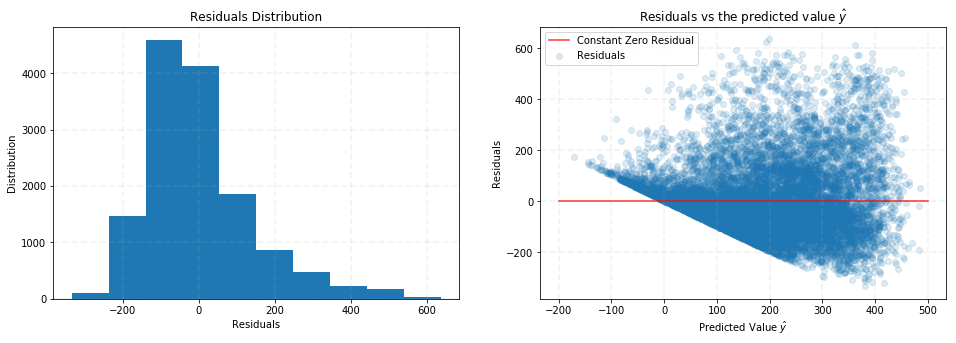

In [32]:
# your code here
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0].hist(ols.resid)
ax[0].set_title(r'Residuals Distribution')
ax[0].set_xlabel(r'Residuals')
ax[0].set_ylabel(r'Distribution')

ax[1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1].scatter(ols.fittedvalues, ols.resid, alpha=0.15, label='Residuals')
# !!!! ols.fittedvalues
ax[1].plot(np.linspace(-200, 500, 2), [0] * len(np.linspace(-200, 500, 2)), c='r', alpha=0.8, label='Constant Zero Residual')
ax[1].set_title(r'Residuals vs the predicted value $\hat{y}$')
# The prefix r before the string denotes a raw string, which allows special characters (such as \ or $) to be interpreted literally rather than as escape sequences.
# $\hat{y}$ is a LaTeX expression 

ax[1].set_xlabel(r'Predicted Value $\hat{y}$')
ax[1].set_ylabel(r'Residuals')
ax[1].legend(loc='upper left')

*your answer here* 

* linearity: Right plot shows clear non-linear relationship, which  constradicts the linearity assumption.
* constant variance: Right plot shows that residuals are not evenly distributed around zero, which contradicts constant variance assumption. 
* normality: Left plot shows that residual distribution is right skewed, which contradicts normality assumption. 

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [119]:
x_train.reset_index(drop =True)

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,fall,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13898,17,0,1,1,0.26,0.2879,0.48,0.0896,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
13899,18,0,1,1,0.26,0.2727,0.48,0.1343,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
13900,20,0,1,1,0.26,0.2576,0.60,0.1642,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
13901,22,0,1,1,0.26,0.2727,0.56,0.1343,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [33]:
# your code here
x_train_poly = x_train.copy().reset_index(drop=True)
x_train_poly = x_train_poly.drop(['temp', 'hour', 'hum'], axis=1)
print(x_train_poly.shape)
print(x_train_poly.index)
x_train_poly.head()

(13903, 28)
RangeIndex(start=0, stop=13903, step=1)


,holiday,year,workingday,atemp,windspeed,spring,summer,fall,Feb,Mar,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0.2879,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0.2727,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0.2727,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0.2879,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0.2879,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
tra = PolynomialFeatures(2, include_bias=False)

In [35]:
array_temp = tra.fit_transform(x_train['temp'].values.reshape(-1,1))
df_temp = pd.DataFrame(array_temp)
df_temp = df_temp.rename(columns={0: 'temp', 1: 'temp_2'})
print(df_temp.shape)
df_temp.head()

(13903, 2)


,temp,temp_2
0,0.24,0.0576
1,0.22,0.0484
2,0.22,0.0484
3,0.24,0.0576
4,0.24,0.0576


In [36]:
array_hour = tra.fit_transform(x_train['hour'].values.reshape(-1,1))
df_hour = pd.DataFrame(array_hour)
df_hour = df_hour.rename(columns={0: 'hour', 1: 'hour_2'})
print(df_hour.shape)
df_hour.head()

(13903, 2)


,hour,hour_2
0,0.0,0.0
1,1.0,1.0
2,2.0,4.0
3,3.0,9.0
4,4.0,16.0


In [37]:
array_hum = tra.fit_transform(x_train['hum'].values.reshape(-1,1))
df_hum = pd.DataFrame(array_hum)
df_hum = df_hum.rename(columns={0: 'hum', 1: 'hum_2'})
print(df_hum.shape)
df_hum.head()

(13903, 2)


,hum,hum_2
0,0.81,0.6561
1,0.80,0.6400
2,0.80,0.6400
3,0.75,0.5625
4,0.75,0.5625


In [38]:
x_train_poly = x_train_poly.merge(df_temp, left_index=True, right_index=True)
# df_temp Object to merge with.
# left_index: Use the index from the left DataFrame as the join key(s).
x_train_poly = x_train_poly.merge(df_hour, left_index=True, right_index=True)
x_train_poly = x_train_poly.merge(df_hum, left_index=True, right_index=True)

In [39]:
y_train_poly = y_train.copy().reset_index(drop=True)
X_train_poly = sm.add_constant(x_train_poly)
OLSModel = sm.OLS(y_train_poly, X_train_poly)
ols_poly = OLSModel.fit()
ols_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     421.8
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:00:17   Log-Likelihood:                -87102.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13869   BIC:                         1.745e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -185.2131     14.016    -13.214      0.000    -212.687    -157.739
holiday      -13.0061      6.056     -2.148      0.032     -24.877      -1.135
year          81.0305      2.199     36.854      0.000      76.721      85.340
workingday    13.2894      2.524      5.265      0.000       8.342      18.237
atemp         67.4957     43.532      1.550      0.121     -17.833     152.824
windspeed     -6.9100      9.920     -0.697      0.486     -26.354      12.534
spring        43.7116      6.805      6.424      0.000      30.374      57.049
summer        33.9087      8.066      4.204      0.000      18.098      49.720
fall          72.1937      6.878     10.497      0.000      58.712      85.675
Feb            1.6487      5.538      0.298      0.766      -9.207      12.504
Mar            9.5583      6.304      1.516      0.129      -2.798      21.914
Apr          -10.7152      9.238     -1.160      0.246     -28.824       7.393
May           -2.7388      9.789     -0.280      0.780     -21.926      16.449
Jun          -23.0368      9.922     -2.322      0.020     -42.485      -3.588
Jul          -53.5230     11.163     -4.795      0.000     -75.405     -31.642
Aug          -23.6944     10.965     -2.161      0.031     -45.188      -2.201
Sept          10.9055      9.887      1.103      0.270      -8.475      30.286
Oct            2.8452      9.262      0.307      0.759     -15.309      20.999
Nov          -16.5926      8.897     -1.865      0.062     -34.032       0.846
Dec           -6.9106      7.078     -0.976      0.329     -20.784       6.963
Mon           -2.4620      2.731     -0.901      0.367      -7.816       2.892
Tue           -3.8629      2.943     -1.313      0.189      -9.631       1.905
Wed            2.1275      2.920      0.729      0.466      -3.596       7.851
Thu           -0.2540      2.922     -0.087      0.931      -5.981       5.473
Fri            4.7347      2.923      1.620      0.105      -0.995      10.465
Sat           16.7983      4.021      4.178      0.000       8.917      24.679
Cloudy        -8.4327      2.680     -3.146      0.002     -13.687      -3.179
Snow         -47.3269      4.583    -10.327      0.000     -56.310     -38.344
Storm         35.5800     90.246      0.394      0.693    -141.315     212.475
temp         132.7247     58.298      2.277      0.023      18.452     246.997
temp_2       109.4437     36.470      3.001      0.003      37.958     180.930
hour          39.5786      0.662     59.777      0.000      38.281      40.876
hour_2        -1.3570      0.027    -50.567      0.000      -1.410      -1.304
hum           11.8636     36.114      0.329      0.743     -58.925      82.652
hum_2       -108.7057     28.944     -3.756      0.000    -165.440     -51.971
==============================================================================
Om

In [40]:
x_test_poly = x_test.copy().reset_index(drop=True)
x_test_poly = x_test_poly.drop(['temp', 'hour', 'hum'], axis=1)

array_temp = tra.fit_transform(x_test['temp'].values.reshape(-1,1))
df_temp = pd.DataFrame(array_temp)
df_temp = df_temp.rename(columns={0: 'temp', 1: 'temp_2'})

array_hour = tra.fit_transform(x_test['hour'].values.reshape(-1,1))
df_hour = pd.DataFrame(array_hour)
df_hour = df_hour.rename(columns={0: 'hour', 1: 'hour_2'})

array_hum = tra.fit_transform(x_test['hum'].values.reshape(-1,1))
df_hum = pd.DataFrame(array_hum)
df_hum = df_hum.rename(columns={0: 'hum', 1: 'hum_2'})

x_test_poly = x_test_poly.merge(df_temp, left_index=True, right_index=True)
x_test_poly = x_test_poly.merge(df_hour, left_index=True, right_index=True)
x_test_poly = x_test_poly.merge(df_hum, left_index=True, right_index=True)

X_test_poly = sm.add_constant(x_test_poly)
y_test_poly = y_test.copy().reset_index(drop=True)

In [41]:
print("R-squared of OLS with polynomial terms for training set: %f" % ols_poly.rsquared)
print("R-squared of OLS with polynomial terms for testing set: %f" % r2_score(y_test_poly, ols_poly.predict(X_test_poly)))

R-squared of OLS with polynomial terms for training set: 0.500904
R-squared of OLS with polynomial terms for testing set: 0.496531


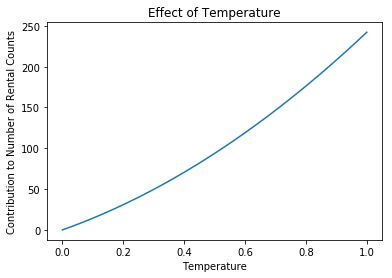

In [42]:
x_vals = np.linspace(0, 1, 1000)
y_vals = ols_poly.params['temp'] * x_vals + ols_poly.params['temp_2'] * x_vals**2
plt.plot(x_vals, y_vals)
plt.title('Effect of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Contribution to Number of Rental Counts')
plt.show()

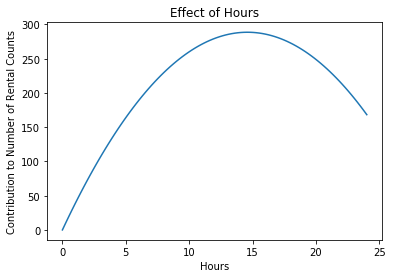

In [43]:
x_vals = np.linspace(0, 24, 100)
y_vals = ols_poly.params['hour'] * x_vals + ols_poly.params['hour_2'] * x_vals**2
plt.plot(x_vals, y_vals)
plt.title('Effect of Hours')
plt.xlabel('Hours')
plt.ylabel('Contribution to Number of Rental Counts')
plt.show()

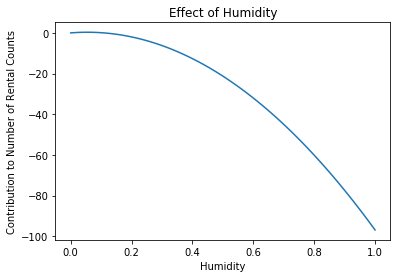

In [44]:
x_vals = np.linspace(0, 1, 100)
y_vals = ols_poly.params['hum'] * x_vals + ols_poly.params['hum_2'] * x_vals**2
plt.plot(x_vals, y_vals)
plt.title('Effect of Humidity')
plt.xlabel('Humidity')
plt.ylabel('Contribution to Number of Rental Counts')
plt.show()

*your answer here*

The OLS model with polynomial terms vs origial OLS model: 
* R-squared in training set: 0.500904 vs 0.406539
* R-squared in testing set: 0.496531 vs 0.406386
* AIC: 1.743e+05 vs 1.767e+05
* BIC: 1.745e+05 vs 1.769e+05

So OLS polynomil model is better. 


Predicted ridership with respect to 
* $temperature$: Statistically significant with p-value < 0.05. All else equal, 1 unit of temperature increase produces 333 more rentals.
* $temperature^2$: Statistically significant with p-value < 0.05. All else equal, 1 unit of 2nd degree polynomial in temperature increase produces 109 more rentals. We expect rentals to increase at higher pace with higher temperature. 
* $hour$: Statistically significant with p-value < 0.05. All else equal, 1 unit of hour increase produces 39 more rentals.
* $hour^2$: Statistically significant with p-value < 0.05. All else equal, 1 unit of 2nd degree polynomial in hour increase produces 1 fewer rentals. We expect rentals to increase during the day which peaks at around 3pm, but then decrease after that.  
* $humidity$: Statistically not significant with p-value > 0.05. No strong relationship can be inferred. 
* $humidity^2$: Statistically significant with p-value < 0.05. All else equal, 1 unit of 2nd degree polynomial in humidity increase produces 109 fewer rentals. 


#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [45]:
# your code here
BSS_train_drop = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
BSS_test_drop = BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)
x_train_drop, y_train_drop = BSS_train_drop.drop(['counts'], axis=1), BSS_train_drop['counts']
x_test_drop, y_test_drop = BSS_test_drop.drop(['counts'], axis=1), BSS_test_drop['counts']

In [46]:
X_train_drop = sm.add_constant(x_train_drop)
OLSModel = sm.OLS(y_train_drop, X_train_drop)
ols_drop = OLSModel.fit()

In [47]:
X_test_drop = sm.add_constant(x_test_drop)
print("R-squared of OLS after dropping redundant predictors for training set: %f" % ols_drop.rsquared)
print("R-squared of OLS after dropping redundant predictors for testing set: %f" % r2_score(y_test_drop, ols_drop.predict(X_test_drop)))

R-squared of OLS after dropping redundant predictors for training set: 0.401686
R-squared of OLS after dropping redundant predictors for testing set: 0.400475


In [439]:
ols_drop.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     358.3
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        20:38:31   Log-Likelihood:                -88363.
No. Observations:               13903   AIC:                         1.768e+05
Df Residuals:                   13876   BIC:                         1.770e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.0627      8.541     -2.349      0.019     -36.805      -3.321
hour           7.2378      0.185     39.095      0.000       6.875       7.601
holiday      -35.8906      7.395     -4.854      0.000     -50.385     -21.396
year          76.3039      2.389     31.945      0.000      71.622      80.986
temp         406.2359     13.279     30.593      0.000     380.208     432.264
hum         -201.5103      7.800    -25.835      0.000    -216.799    -186.221
windspeed     11.9668     10.448      1.145      0.252      -8.512      32.446
Feb           -7.6897      5.986     -1.285      0.199     -19.422       4.043
Mar            2.8889      6.158      0.469      0.639      -9.182      14.960
Apr            1.0237      6.594      0.155      0.877     -11.902      13.950
May            7.2426      7.613      0.951      0.341      -7.680      22.165
Jun          -30.6611      8.346     -3.674      0.000     -47.020     -14.302
Jul          -67.7620      9.062     -7.477      0.000     -85.525     -49.999
Aug          -34.2712      8.628     -3.972      0.000     -51.183     -17.359
Sept          20.6406      7.882      2.619      0.009       5.191      36.090
Oct           50.7025      6.823      7.431      0.000      37.329      64.076
Nov           42.3211      6.111      6.926      0.000      30.344      54.299
Dec           34.2134      5.952      5.748      0.000      22.546      45.881
Mon            9.2907      4.570      2.033      0.042       0.333      18.248
Tue            4.7929      4.442      1.079      0.281      -3.914      13.500
Wed           13.2143      4.417      2.992      0.003       4.557      21.871
Thu            8.0051      4.445      1.801      0.072      -0.708      16.718
Fri           13.0474      4.429      2.946      0.003       4.367      21.728
Sat           14.1461      4.397      3.217      0.001       5.528      22.764
Cloudy         6.7192      2.909      2.310      0.021       1.018      12.421
Snow         -29.1668      4.828     -6.041      0.000     -38.631     -19.703
Storm         40.3125     98.759      0.408      0.683    -153.267     233.893
==============================================================================
Omnibus:                     2850.389   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5702.134
Skew:                           1.231   Prob(JB):                         0.00
Kurtosis:                       4.944   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
""

*your answer here*

Multicolinearity can lead correlated factors to compete with each other to explain the variation in response variable, which will overestimate the standard error, and thus underestimate the t-stats of the correlated factors. 


The estimates are more sensible in the model: 
* temp vs atemp: The origianl coefficient on atemp is now added to the factor temp, which makes temp more significnt.
* workingday vs weekday: Droping workingday from the regression model makes some of the weekdays more significant. 
* season vs month: Droping season from the regression model makes some of the months more signficant.


R-squared, AIC and BIC are all comparable before and after droping the redundant variables. 

<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [39]:
tmp=[1,2,3]
tmp2 = ["a"]

tmp.append(tmp2)
tmp2.append("b")
#tmp2 = ["b"]
tmp

# tmp2 = ["b"] make tmp2 point to another list
# tmp2.append() change the original list

[1, 2, 3, ['a', 'b']]

In [43]:
models = []
selected_predictor = []
predictors = []
cols = train_X_poly.drop("const", axis =1).columns

for i in range(len(cols)):
    results = []
    r2s = []
    for col in cols:
        forward_x = train_X_poly[[col]+selected_predictor]
        forward_X = sm.add_constant(forward_x)
        result = OLS(train_y_poly, forward_X).fit()
        r2 = result.rsquared
        r2s.append(r2)
        results.append(result)
    r_max = max(r2s)
    index = r2s.index(r_max)
    selected_predictor.append(cols[index])
    predictors.append(selected_predictor.copy())
    model = results[index]
    models.append(model)
    cols = cols.drop(cols[index])


bics= []
for model in models:
    bic = model.bic
    bics.append(bic)

bic_min = min(bics)
bic_index = bics.index(bic_min)
model = models[bic_index]
predictor = predictors[bic_index]
predictor


['temp',
 'hour',
 'hour2',
 'year',
 'hum2',
 'fall',
 'Jul',
 'Snow',
 'spring',
 'Sept',
 'holiday',
 'Cloudy']

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        13:39:51   Log-Likelihood:                -87144.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13890   BIC:                         1.744e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -189.1223      5.283    -35.795      0.000    -199.479    -178.766
Cloudy        -8.4814      2.666     -3.181      0.001     -13.707      -3.256
temp         310.9097      6.890     45.125      0.000     297.404     324.415
hour          39.5749      0.647     61.177      0.000      38.307      40.843
hour2         -1.3582      0.026    -51.420      0.000      -1.410      -1.306
year          80.3153      2.182     36.804      0.000      76.038      84.593
hum2         -97.3713      5.534    -17.595      0.000    -108.219     -86.524
fall          56.0162      2.797     20.026      0.000      50.533      61.499
Jul          -25.6107      4.679     -5.473      0.000     -34.783     -16.438
Snow         -48.1081      4.447    -10.819      0.000     -56.824     -39.392
spring        25.8171      2.910      8.873      0.000      20.114      31.520
Sept          29.2489      4.302      6.798      0.000      20.816      37.682
holiday      -27.4291      6.432     -4.265      0.000     -40.037     -14.822
==============================================================================
Omnibus:                     2990.921   Durbin-Watson:                   0.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6264.394
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                       5.102   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
train_y_poly

0         16
1         40
2         32
3         13
4          1
        ... 
17372    164
17373    122
17375     89
17377     61
17378     49
Name: counts, Length: 13903, dtype: int64

In [54]:
final_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 counts   R-squared (uncentered):                   0.737
Model:                            OLS   Adj. R-squared (uncentered):              0.737
Method:                 Least Squares   F-statistic:                              3250.
Date:                Thu, 25 May 2023   Prob (F-statistic):                        0.00
Time:                        13:41:48   Log-Likelihood:                         -87757.
No. Observations:               13903   AIC:                                  1.755e+05
Df Residuals:                   13891   BIC:                                  1.756e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp         202.1365      6.462     31.279      0.000     189.469     214.804
hour          26.5910      0.560     47.504      0.000      25.494      27.688
hour2         -0.9069      0.024    -37.388      0.000      -0.954      -0.859
year          60.4718      2.206     27.415      0.000      56.148      64.795
hum2        -210.4480      4.749    -44.318      0.000    -219.756    -201.140
fall          40.4201      2.888     13.998      0.000      34.760      46.080
Jul          -11.2106      4.872     -2.301      0.021     -20.761      -1.660
Snow         -25.6573      4.600     -5.577      0.000     -34.675     -16.640
spring        20.7122      3.037      6.820      0.000      14.759      26.665
Sept          47.9000      4.463     10.732      0.000      39.152      56.648
holiday      -39.8628      6.712     -5.939      0.000     -53.019     -26.706
Cloudy        -5.5060      2.785     -1.977      0.048     -10.964      -0.047
==============================================================================
Omnibus:                     3557.305   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8438.715
Skew:                           1.433   Prob(JB):                         0.00
Kurtosis:                       5.521   Cond. No.                     1.67e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
final_X_train

,temp,hour,hour2,year,hum2,fall,Jul,Snow,spring,Sept,holiday,Cloudy
0,0.24,0,0,0,0.6561,0,0,0,0,0,0,0
1,0.22,1,1,0,0.6400,0,0,0,0,0,0,0
2,0.22,2,4,0,0.6400,0,0,0,0,0,0,0
3,0.24,3,9,0,0.5625,0,0,0,0,0,0,0
4,0.24,4,16,0,0.5625,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17372,0.26,17,289,1,0.2304,0,0,0,0,0,0,1
17373,0.26,18,324,1,0.2304,0,0,0,0,0,0,1
17375,0.26,20,400,1,0.3600,0,0,0,0,0,0,1
17377,0.26,22,484,1,0.3136,0,0,0,0,0,0,0


In [57]:
final_x_train = train_X_poly[predictor]
final_x_test = test_X_poly[predictor]

final_X_train = sm.add_constant(final_x_train)
final_X_test = sm.add_constant(final_x_test)
final_result = OLS(train_y_poly, final_X_train).fit()
print("the r squared score for train set is %f." %final_result.rsquared)
print("the r squared score for test set is %f." %r2_score(test_y, final_result.predict(final_X_test)))



the r squared score for train set is 0.497927.
the r squared score for test set is 0.494310.


### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [48]:
# your code here
print(x_train_poly.shape, y_train_poly.shape)
x_train_poly.head()

(13903, 34) (13903,)


,holiday,year,workingday,atemp,windspeed,spring,summer,fall,Feb,Mar,...,Sat,Cloudy,Snow,Storm,temp,temp_2,hour,hour_2,hum,hum_2
0,0,0,0,0.2879,0.0,0,0,0,0,0,...,1,0,0,0,0.24,0.0576,0.0,0.0,0.81,0.6561
1,0,0,0,0.2727,0.0,0,0,0,0,0,...,1,0,0,0,0.22,0.0484,1.0,1.0,0.80,0.6400
2,0,0,0,0.2727,0.0,0,0,0,0,0,...,1,0,0,0,0.22,0.0484,2.0,4.0,0.80,0.6400
3,0,0,0,0.2879,0.0,0,0,0,0,0,...,1,0,0,0,0.24,0.0576,3.0,9.0,0.75,0.5625
4,0,0,0,0.2879,0.0,0,0,0,0,0,...,1,0,0,0,0.24,0.0576,4.0,16.0,0.75,0.5625


In [49]:
# your code here
def find_best_subset(x, y, best_subset):
    best_bic = np.inf
    # IEEE 754 floating point representation of (positive) infinity.
    best_model_data = None

    predictors = x.columns
    candidates = set(best_subset) ^ set(predictors)
    # The ^ operator is the symmetric difference operator for sets. It returns a new set that contains elements that are in either of the two sets, but not in both sets.
    subsets = [best_subset + [c] for c in candidates]

    # Inner loop: iterate through subsets
    for subset in subsets:
        
        # Fit regression model using ‘subset’ 
        # Keep track of subset with lowest BIC
        features = list(subset)
        x_subset = sm.add_constant(x[features])

        model = sm.OLS(y, x_subset).fit()
        bic = model.bic

        # Check if we get a lower BIC value than than current min BIC.
        # If so, update our best subset 
        if bic < best_bic:
            best_bic = bic
            best_model_data = {
                'subset': features,
                'model': model
            }
    return best_model_data

In [50]:
def forward_step_wise_selection(x, y):
    """Forward step wise predictor combinations

    Parameters:
    -----------
    x : DataFrame of predictors/features
    y : response varible 
    
    
    Returns:
    -----------
    
    Dataframe of model comparisons and OLS Model with 
    lowest BIC for subset with the lowest BIC
    
    """
    
    predictors = x.columns
    
    stats = []
    models = dict()
    best_subset = []
    
    # Outer loop: iterate over sizes 1, 2 .... d
    for k in range(1, len(predictors)):       
        best_size_k_model = find_best_subset(x, y, best_subset)
        best_subset = best_size_k_model['subset']
        best_model = best_size_k_model['model']
        
        stats.append({
            'k': k,
            'formula': "y ~ {}".format(' + '.join(best_subset)),
            'bic': best_model.bic,
            'features': best_subset,
            'model': best_model
        })
        models[k] = best_model
        
    return pd.DataFrame(stats), models

In [51]:
stats, models = forward_step_wise_selection(x_train_poly, y_train_poly)

In [52]:
stats[['k', 'bic', 'features']]

,k,bic,features
0,1,181379.567621,[temp]
1,2,179312.318838,"[temp, hour]"
2,3,176822.942085,"[temp, hour, hour_2]"
3,4,175475.152084,"[temp, hour, hour_2, year]"
4,5,175050.969747,"[temp, hour, hour_2, year, hum_2]"
5,6,174691.049974,"[temp, hour, hour_2, year, hum_2, fall]"
6,7,174595.468053,"[temp, hour, hour_2, year, hum_2, fall, Jul]"
7,8,174500.568450,"[temp, hour, hour_2, year, hum_2, fall, Jul, S..."
8,9,174457.138957,"[temp, hour, hour_2, year, hum_2, fall, Jul, S..."
9,10,174420.945354,"[temp, hour, hour_2, year, hum_2, fall, Jul, S..."


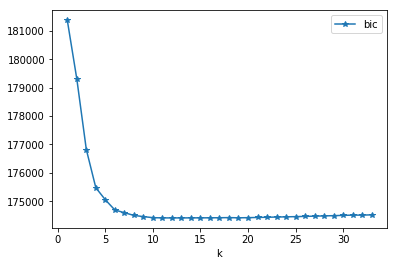

In [53]:
stats.plot(x='k', y='bic', marker='*')

In [54]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 5 columns):
bic         33 non-null float64
features    33 non-null object
formula     33 non-null object
k           33 non-null int64
model       33 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ KB


In [55]:
best_stat = stats.iloc[stats.bic.idxmin()]
print(best_stat.model.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 04 Oct 2018   Prob (F-statistic):               0.00
Time:                        23:01:03   Log-Likelihood:                -87144.
No. Observations:               13903   AIC:                         1.743e+05
Df Residuals:                   13890   BIC:                         1.744e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -189.1223      5.283    -35.795      0.0

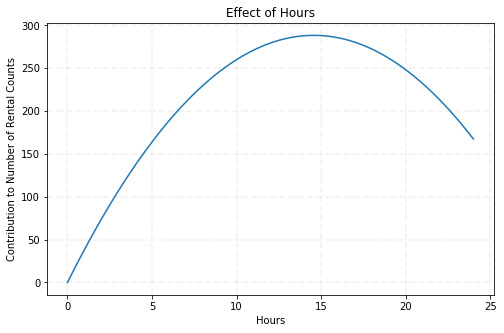

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

x_vals_hour = np.linspace(0, 24, 100)
y_vals_hour = best_stat.model.params['hour'] * x_vals_hour + best_stat.model.params['hour_2'] * x_vals_hour**2
ax.grid(True, lw=1.75, ls='--', alpha=0.15)
ax.plot(x_vals_hour, y_vals_hour)
ax.set_title('Effect of Hours')
ax.set_xlabel('Hours')
ax.set_ylabel('Contribution to Number of Rental Counts')
fig.savefig("fig/hours.png")

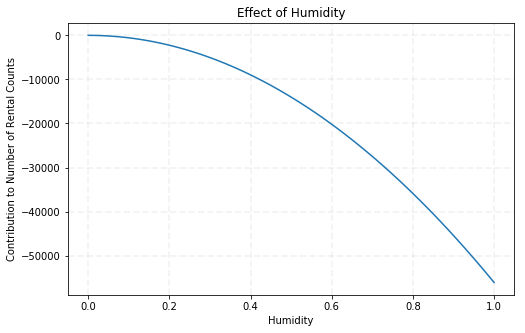

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

x_vals_hum = np.linspace(0, 1, 100)
y_vals_hum = best_stat.model.params['hum_2'] * x_vals_hour**2
ax.grid(True, lw=1.75, ls='--', alpha=0.15)
ax.plot(x_vals_hum, y_vals_hum)
ax.set_title('Effect of Humidity')
ax.set_xlabel('Humidity')
ax.set_ylabel('Contribution to Number of Rental Counts')
fig.savefig("fig/humidity.png")

#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

*your answer here*

Yes, forward selection method eliminated workingday, atemp, and summer, but kept spring and fall. 

Spring includes March, April, and May. It's not surprising that Spring is kept since none of the March, April, or May is included in the model. There is no perfect collinearity in the model that can replace Spring. 

Fall includes September, October, and November. Even though September is included, Fall still includes information about October and November. There is no perfect collinearity in the model that can replace Fall.

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [58]:
# your code here
x_test_step = x_test_poly[best_stat.features]
X_test_step = sm.add_constant(x_test_step)
print("R-squared of OLS step-wise model for training set: %f" % best_stat.model.rsquared)
print("Adjusted R-squared of OLS step-wise model for training set: %f" % best_stat.model.rsquared_adj)
# !!!!!!!!
print("R-squared of OLS step-wise model for testing set: %f" % r2_score(y_test_poly, best_stat.model.predict(X_test_step)))

print("R-squared of OLS polynomial model for training set: %f" % ols_poly.rsquared)
print("Adjusted R-squared of OLS polynomial model for training set: %f" % ols_poly.rsquared_adj)
print("R-squared of OLS polynomial model for testing set: %f" % r2_score(y_test_poly, ols_poly.predict(X_test_poly)))

R-squared of OLS step-wise model for training set: 0.497927
Adjusted R-squared of OLS step-wise model for training set: 0.497494
R-squared of OLS step-wise model for testing set: 0.494310
R-squared of OLS polynomial model for training set: 0.500904
Adjusted R-squared of OLS polynomial model for training set: 0.499717
R-squared of OLS polynomial model for testing set: 0.496531


In [59]:
print("BIC of OLS step-wise model: %f" % best_stat.model.bic)
print("BIC of OLS polynomial model: %f" % ols_poly.bic)

BIC of OLS step-wise model: 174411.588858
BIC of OLS polynomial model: 174529.253392


*your answer here*

The polynomial model is slightly better than the step-wise model in terms of R-squared in training and testing set, but step-wise model is better in terms of BIC.

#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




After our exploratory data analysis and modeling, we would like to recommend the following model to predict the hourly demand for rental bikes: 

$$Rentals = -189+310Temp+39Hour-Hour^2+80Year-97Hum^2+56Fall-26July-48Snow+25Spring+29Sept-27Holi-8Cloudy $$

The model performs reasonably well, which can explain around 50% of the variation in the hourly demand all significant predictors. The prediction power is very close to the polynomial model, but with less predictors. 

Regarding the operating hours, we found that ridership quickly becomes higher from midnight till peaks around 3pm in the afternoon, and dramatically decreases after 8pm in the night. Based on this pattern, we would like to recommend differentiating rental fare by hours, for example, 30% discount rate before 8am and after 8pm. 
![bike_sharing](fig/hours.png)

Regarding the humidity and weather, we found high humidity has a quadratic negative impact on the ridership, since fewer people would  ride in the rain. Of couse, people also don't like to ride in the snow or cloudy days. Luckily, weather prediction might be helpful for us to give a discount rates beforehand. In the meanwhile, we should warn the danger of riding during snowing or raining days to potential riders.
![bike_sharing](fig/humidity.png)
![bike_sharing](fig/weather.png)

Regarding riders, we found that registered riders are more consistent than casual riders. We should have more promotion events in good weather and good season to attract more people to register for the program for revenue growth.  
![bike_sharing](fig/riders.png)

Regarding seasonality, we found that riders prefer spring and fall seasons, like September but don't like July and holidays. Accordingly, we would suggest dicsounts event during holidays to attract price-sensitive customers, hold community events like riding competitions to let more people know the healthy aspect of riding during spring and fall season.    
![bike_sharing](fig/season.png)

Overall, we love this program, and firmly believe our recommendations would help for revenue growth. 